In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def estimate_convertible_bond_value(S0, K, V, r, q, T, sigma, credit_spread, c, N):
    call_price = 1.10 * V
    put_price = 1.05 * V

    dt = T / N  # Time step
    # Adjusting the up and down factors
    u = np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - q - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt))
    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))

    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initialize convertible bond value tree
    cb_tree = np.zeros((N + 1, N + 1))
    conversion_probabilities = np.zeros((N + 1, N + 1))
    credit_adjusted_rates = np.zeros((N + 1, N + 1))

    #action = np.empty((N + 1, N + 1), dtype=object)

    # Set the terminal values of the convertible bond at maturity
    for j in range(N + 1):
        conversion_value = stock_tree[j, N] / K * V
        cb_tree[j, N] = max(conversion_value,  V + c * V)
        credit_adjusted_rates[j, N] = r if cb_tree[j, N] == conversion_value else r + credit_spread
        conversion_probabilities[j, N] = 1 if cb_tree[j, N] == conversion_value else 0

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):

            convert_value = stock_tree[j, i]*V / K
            discounted_cb_value_ju = cb_tree[j, i + 1] / (1 + credit_adjusted_rates[j, i + 1] * dt)
            discounted_cb_value_jd = cb_tree[j + 1, i + 1] / (1 + credit_adjusted_rates[j + 1, i + 1] * dt)
            hold_value1 = 0.5 * (discounted_cb_value_ju + discounted_cb_value_jd)
            hold_value= hold_value1 if i % (N/20) != 0 else hold_value1 + c * V
            call_value = call_price if 2 <= (i / N) * T < 5 and i % (N/20) != 0 else call_price + c * V if 2 <= (i / N) * T < 5 else 0
            put_value = put_price if 3 <= (i / N) * T < 5 and i % (N/20) != 0 else put_price + c * V if 3 <= (i / N) * T < 5 else 0

            if 0 <= (i / N * T) < 2:
                cb_tree[j, i] = max(convert_value, hold_value)
            elif 2 <= (i / N * T) < 3:
                cb_tree[j, i] = max(convert_value, min(hold_value, call_value))
            else:
                cb_tree[j, i] = max(convert_value, put_value, min(hold_value, call_value))

            # Update rates and probabilities
            if cb_tree[j, i] == convert_value:
                credit_adjusted_rates[j, i] = r
                conversion_probabilities[j, i] = 1
                #action[j,i]="X"
            elif cb_tree[j, i] == put_value and 3<=(i / N * T)<5 :
                credit_adjusted_rates[j, i] = r + credit_spread
                conversion_probabilities[j, i] = 0
                #action[j,i]="P"
            elif cb_tree[j, i] == call_value and 2<=(i / N * T) <5:
                credit_adjusted_rates[j, i] = r + credit_spread
                conversion_probabilities[j, i] = 0
                #action[j,i]="C"
            else:
                conversion_probabilities[j, i] = 0.5 * (conversion_probabilities[j, i + 1] + conversion_probabilities[j + 1, i + 1])
                credit_adjusted_rates[j, i] = conversion_probabilities[j, i + 1] * r + (1 - conversion_probabilities[j + 1, i + 1]) * (r + credit_spread)
                #action[j,i]="H"

    return cb_tree[0, 0]


estimated_value = estimate_convertible_bond_value(S0=182.68, K=200, V=1000, r=0.04, q=0.005, T=5, sigma=0.3, credit_spread=0.02, c=0.05/4, N=800)
print("Estimated Convertible Bond Value:", estimated_value)


Estimated Convertible Bond Value: 1172.7584922625933


In [ ]:
S0_range = [160,162.5,165,167.5,170,172.5,175,177.5,180,182.68,185,187.5,190,192.5,195,197.5,200,202.5,205]
credit_spread_range = np.arange(0, 0.19, 0.01)
sigma_range = np.arange(0.2, 0.45, 0.05)


In [ ]:
results_credit_spread_sigma = pd.DataFrame(index=credit_spread_range, columns=sigma_range)
results_S0_sigma = pd.DataFrame(index=S0_range, columns=sigma_range)

# credit_spread and sigma
for credit_spread in credit_spread_range:
    for sigma in sigma_range:
        cb_value = estimate_convertible_bond_value(182.68, 200, 1000, 0.04, 0.005, 5, sigma, credit_spread, 0.05/4, 800)
        results_credit_spread_sigma.at[credit_spread, sigma] = cb_value

#  S0 and sigma
for S0 in S0_range:
    for sigma in sigma_range:
        cb_value = estimate_convertible_bond_value(S0, 200, 1000, 0.04, 0.005, 5, sigma, 0.02, 0.05/4, 800)
        results_S0_sigma.at[S0, sigma] = cb_value


with pd.ExcelWriter('GS-cp.xlsx') as writer:
    results_credit_spread_sigma.to_excel(writer, sheet_name='Credit_Spread_Sigma')
    results_S0_sigma.to_excel(writer, sheet_name='S0_Sigma')


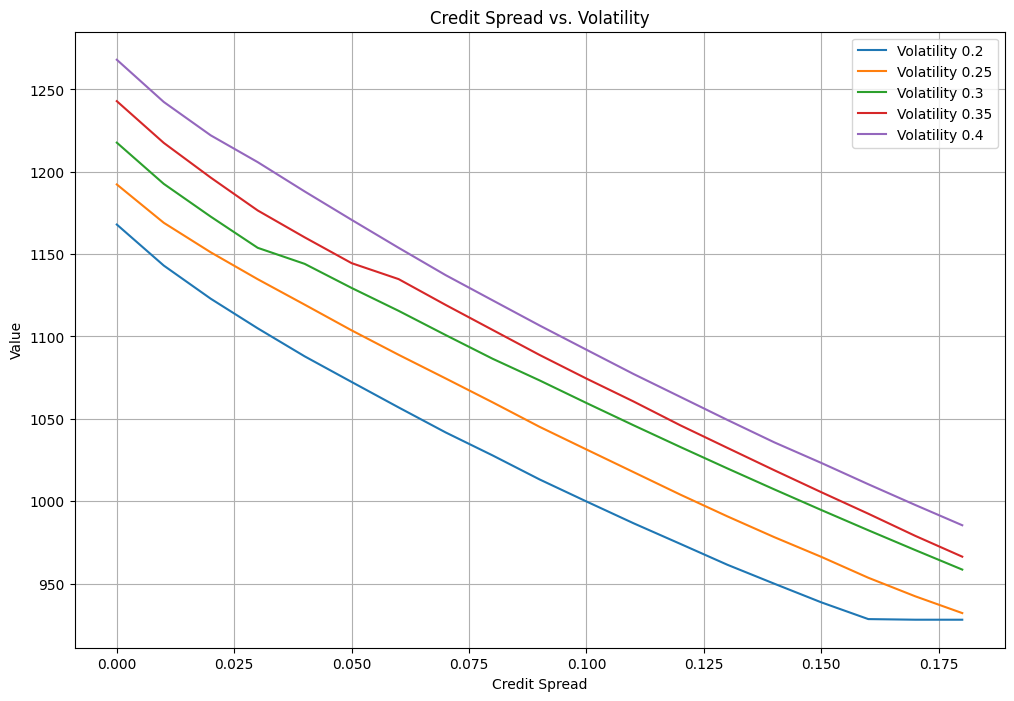

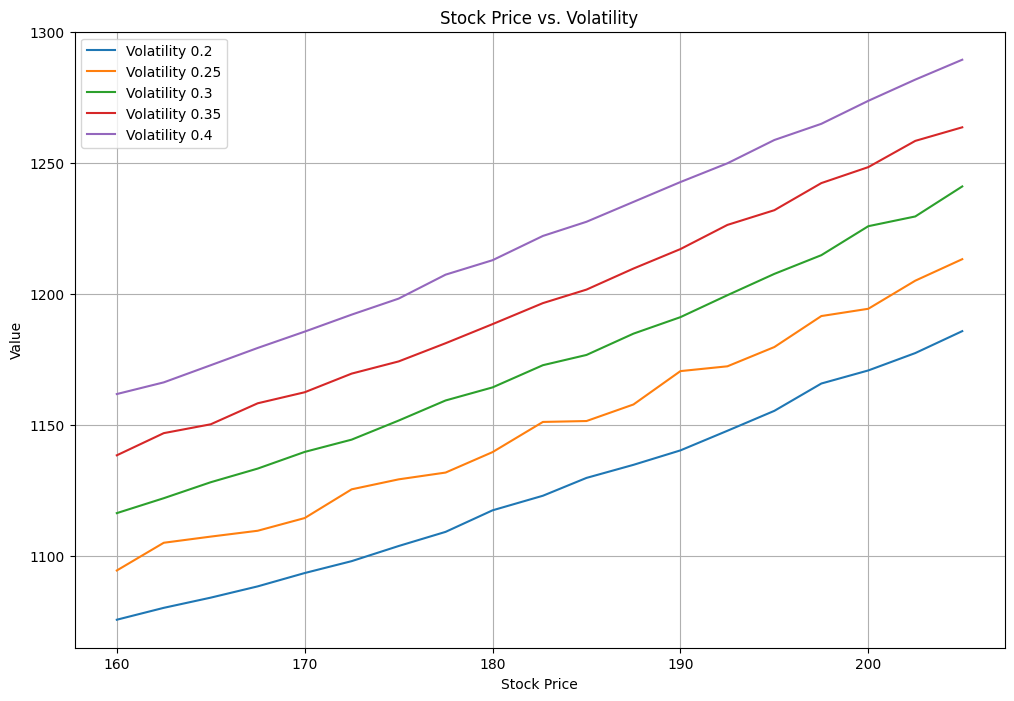

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'GS-cp.xlsx'
df = pd.read_excel(file_path, sheet_name=None)


credit_spread_data = df['Credit_Spread_Sigma'].iloc[:, :6]


plt.figure(figsize=(12, 8))
for col in credit_spread_data.columns[1:]:
    plt.plot(credit_spread_data.iloc[:, 0], credit_spread_data[col], label=f'Volatility {col}')

plt.title('Credit Spread vs. Volatility')
plt.xlabel('Credit Spread')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

stock_price_data = df['S0_Sigma'].iloc[:, :6].dropna(axis=1, how='all')
stock_price_data.columns = credit_spread_data.columns


plt.figure(figsize=(12, 8))
for col in stock_price_data.columns[1:]:
    plt.plot(stock_price_data.iloc[:, 0], stock_price_data[col], label=f'Volatility {col}')

plt.title('Stock Price vs. Volatility')
plt.xlabel('Stock Price')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


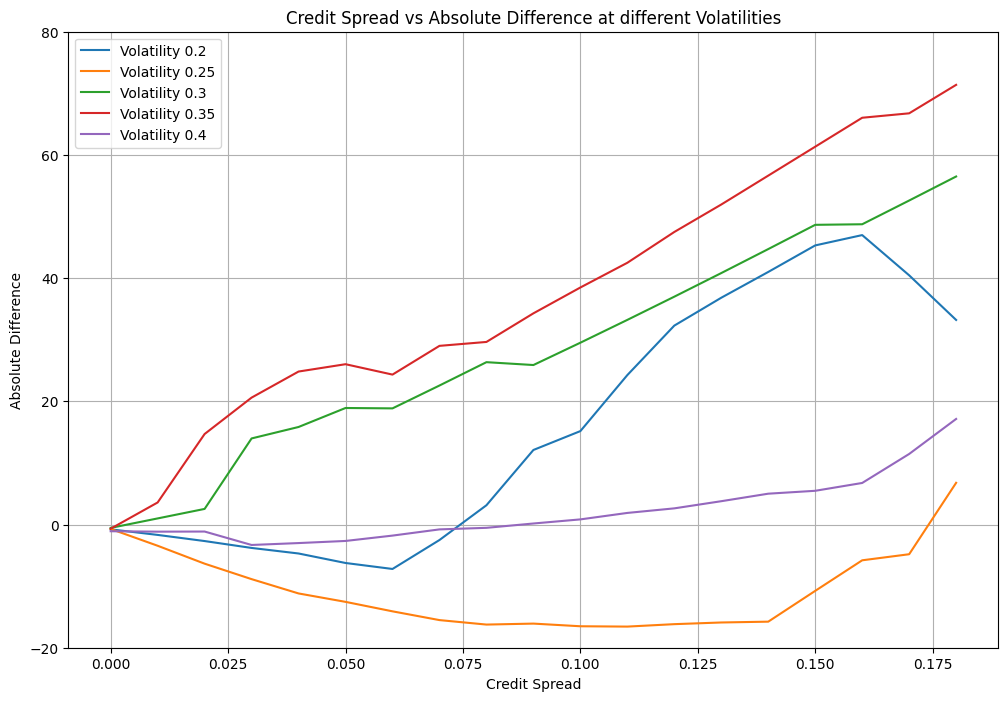

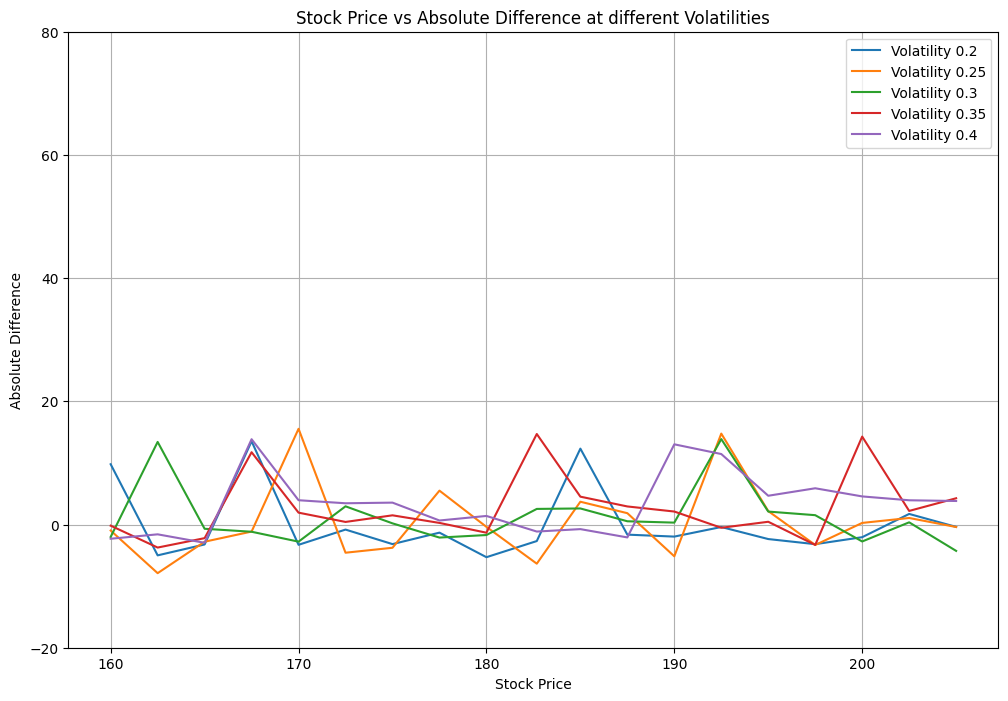

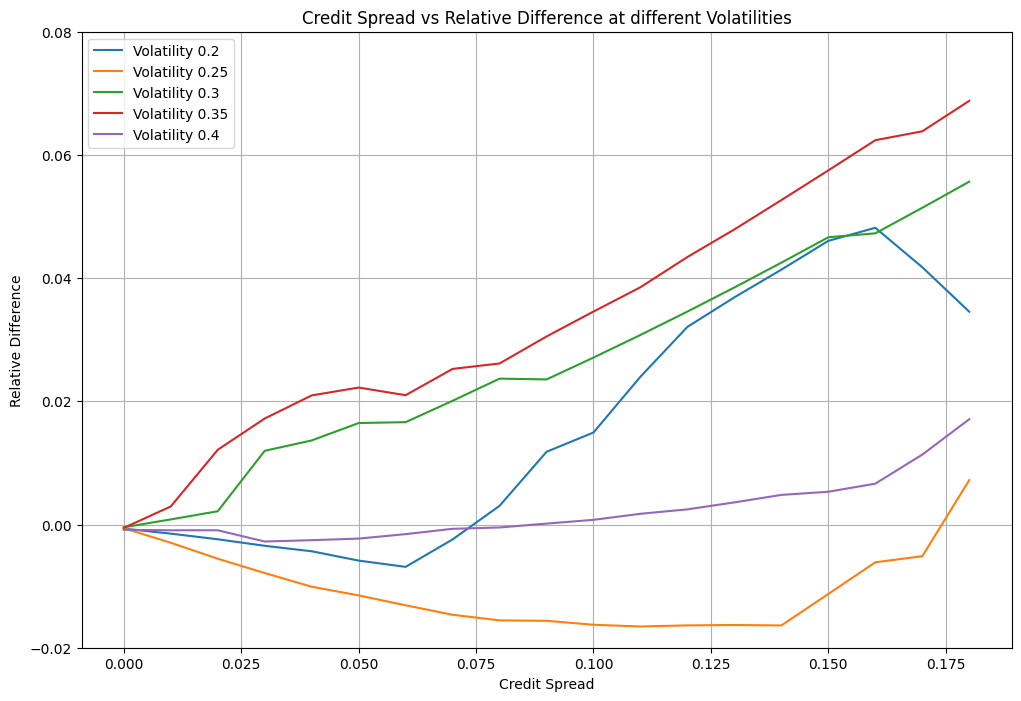

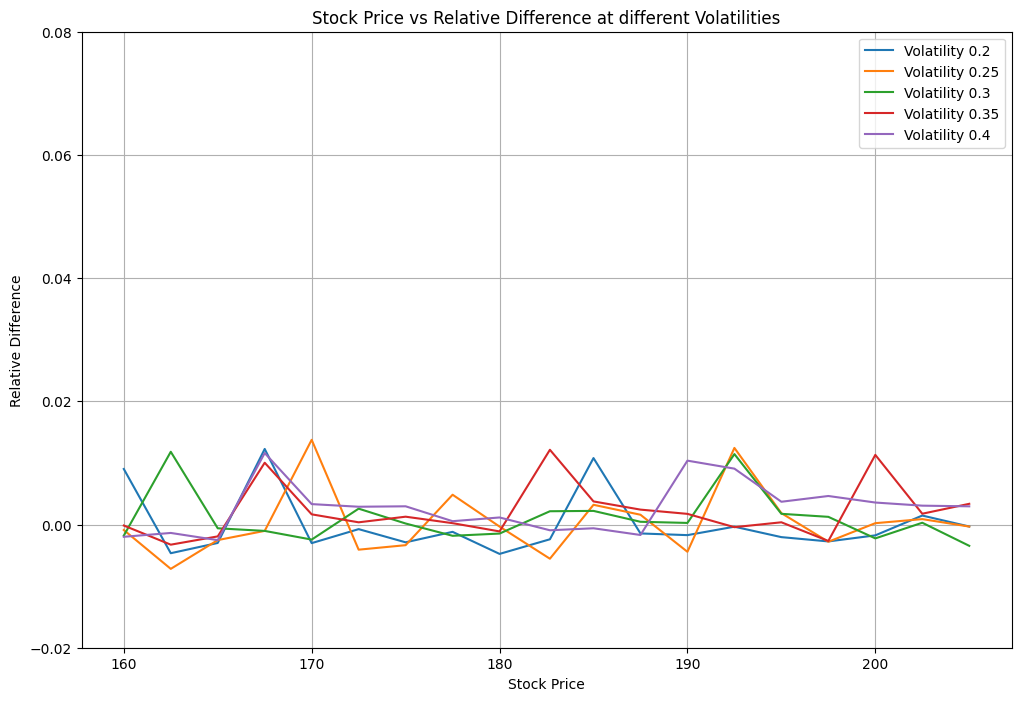

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path1 = 'GS-cp.xlsx'
df1 = pd.read_excel(file_path1, sheet_name=None)

file_path2 = 'STFM.xlsx'
df2 = pd.read_excel(file_path2, sheet_name=None)

credit_spread_data = df1['Credit_Spread_Sigma'].iloc[:, :6]

stock_price_data = df1['S0_Sigma'].iloc[:, :6].dropna(axis=1, how='all')
stock_price_data.columns = credit_spread_data.columns

standard_credit_spread_data = df2['Sheet1'].iloc[:, :6].dropna(axis=1, how='all')
standard_stock_price_data = df2['Sheet1'].iloc[:, 8:14].dropna(axis=1, how='all')

standard_stock_price_data.columns=standard_credit_spread_data.columns=credit_spread_data.columns

#1
plt.figure(figsize=(12, 8))
for col in credit_spread_data.columns[1:]:
    plt.plot(credit_spread_data.iloc[:, 0], standard_credit_spread_data[col]-credit_spread_data[col], label=f'Volatility {col}')

plt.title('Credit Spread vs Absolute Difference at different Volatilities')
plt.xlabel('Credit Spread')
plt.ylabel('Absolute Difference')
plt.legend()
plt.grid(True)
plt.ylim(-20, 80)
plt.show()

#2
plt.figure(figsize=(12, 8))
for col in stock_price_data.columns[1:]:
    plt.plot(stock_price_data.iloc[:, 0], standard_stock_price_data[col]-stock_price_data[col], label=f'Volatility {col}')

plt.title('Stock Price vs Absolute Difference at different Volatilities')
plt.xlabel('Stock Price')
plt.ylabel('Absolute Difference')
plt.legend()
plt.grid(True)
plt.ylim(-20, 80)
plt.show()


#3
plt.figure(figsize=(12, 8))
for col in credit_spread_data.columns[1:]:
    plt.plot(credit_spread_data.iloc[:, 0], (standard_credit_spread_data[col]-credit_spread_data[col])/standard_credit_spread_data[col], label=f'Volatility {col}')

plt.title('Credit Spread vs Relative Difference at different Volatilities')
plt.xlabel('Credit Spread')
plt.ylabel('Relative Difference')
plt.legend()
plt.grid(True)
plt.ylim(-0.02, 0.08)
plt.show()

#4
plt.figure(figsize=(12, 8))
for col in stock_price_data.columns[1:]:
    plt.plot(stock_price_data.iloc[:, 0], (standard_stock_price_data[col]-stock_price_data[col])/standard_stock_price_data[col], label=f'Volatility {col}')

plt.title('Stock Price vs Relative Difference at different Volatilities')
plt.xlabel('Stock Price')
plt.ylabel('Relative Difference')
plt.legend()
plt.grid(True)
plt.ylim(-0.02, 0.08)
plt.show()





